Step 1: Setting up the environment...
GPU 0: Tesla T4 (UUID: GPU-4f0a67d3-0e1f-289a-9b99-affc11eac8c1)

GPUs visible to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Step 2: Creating project folders...

Step 3: Downloading and preparing the dataset...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathuminakaushal11
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka


100%|██████████| 960M/960M [00:07<00:00, 142MB/s]




Fixing dataset folder structure...

Splitting dataset into train, validation, and test sets (70%, 20%, 10%)...


Copying files: 1196 files [00:04, 256.22 files/s]


Step 4: Defining constants and setting up data generators...
Found 835 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 125 images belonging to 8 classes.



Classes found: ['Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight', 'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot']

Step 5: Building and compiling the final EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,369,515 (20.48 MB)

 Trainable params: 5,327,492 (20.32 MB)

 Non-trainable params: 42,023 (164.16 KB)


Step 6: Starting final model training for 30 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.1499 - loss: 2.1073 - val_accuracy: 0.1822 - val_loss: 2.0756
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1735 - loss: 2.0379 - val_accuracy: 0.1610 - val_loss: 2.0765
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2453 - loss: 1.9631 - val_accuracy: 0.1610 - val_loss: 2.0767
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3049 - loss: 1.8873 - val_accuracy: 0.1059 - val_loss: 2.0803
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3468 - loss: 1.8029 - val_accuracy: 0.1059 - val_loss: 2.0866
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4028 - loss: 1.7383 - val_accuracy: 0.1568 - val_loss: 2.0973
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4639 - loss: 1.6506 - val_accuracy: 0.1525 - val_loss: 2.1070
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5182 - loss: 1.5675 - val_accuracy: 0.1017 - val_loss

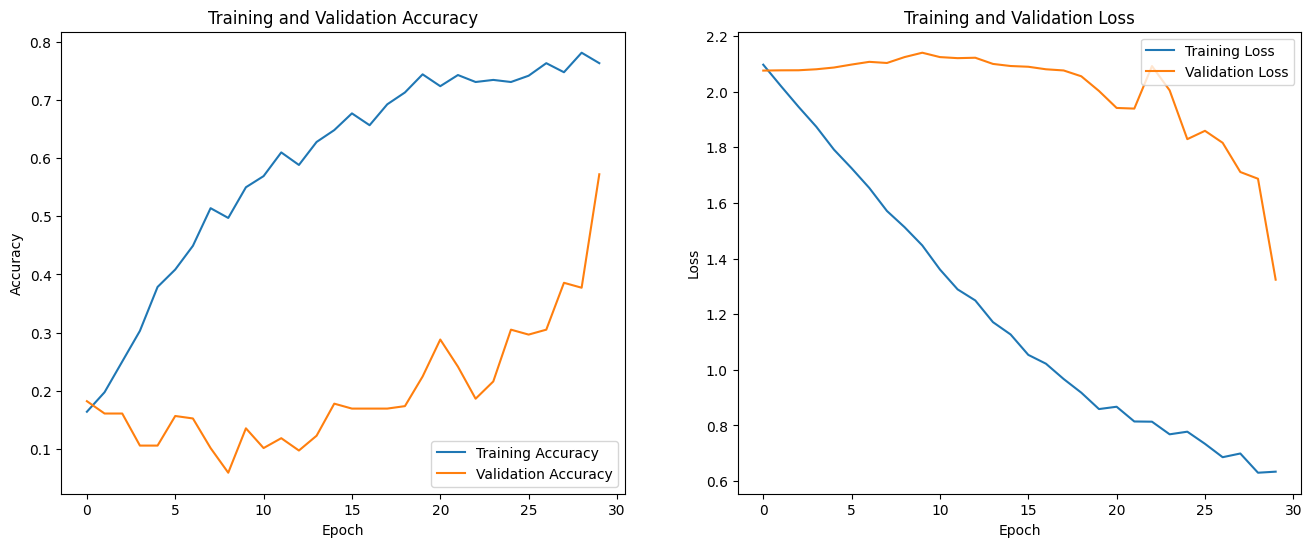


Evaluating on the unseen test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5332 - loss: 1.4063

Final Test Accuracy: 54.40%
Final Test Loss: 1.3703
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step

Final Classification Report (on Test Set):

               precision    recall  f1-score   support

   Algal Leaf       0.75      0.38      0.50        16
  Anthracnose       0.64      0.64      0.64        14
Bird Eye Spot       0.54      0.50      0.52        14
 Brown Blight       0.50      0.33      0.40        15
   Gray Light       0.64      0.64      0.64        14
      Healthy       0.26      0.80      0.39        10
Red Leaf Spot       1.00      0.78      0.88        23
   White Spot       0.35      0.32      0.33        19

     accuracy                           0.54       125
    macro avg       0.59      0.55      0.54       125
 weighted avg       0.62      0.54      0.56       125


Final Confusion Matrix (on Test Set):



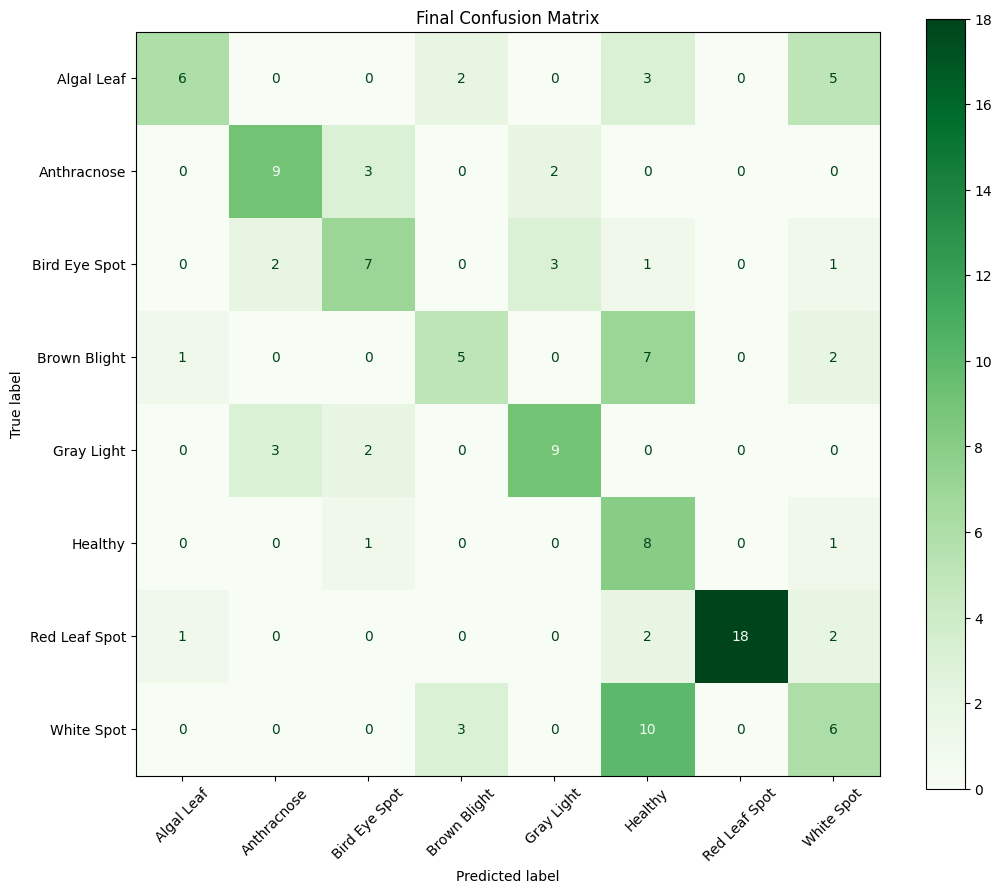


Step 8: Saving the final model...
Model saved successfully to: /content/artifacts/efficientnetB0_final_model.h5

Step 9: Testing the saved model on a single random image...


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


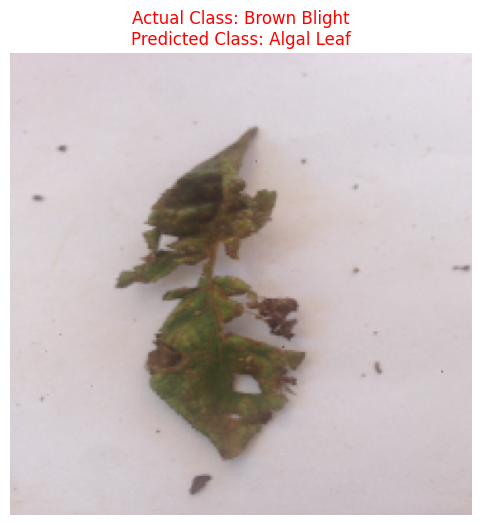

In [1]:
# ==============================================================================
# SE4050 - Deep Learning Assignment
# Component: EfficientNetB0 Model (Final Code with GPU Fix)
# ==============================================================================

# ------------------------------------------------------------------------------
# Step 1: Professional Setup and Environment Checks
# ------------------------------------------------------------------------------
print("Step 1: Setting up the environment...")
# Check for GPU - THIS SHOULD NOW SHOW A GPU
!nvidia-smi -L || echo "CRITICAL WARNING: No GPU found."

!pip install -q opendatasets split-folders
import os, shutil, random
import numpy as np
import tensorflow as tf
import opendatasets as od
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("\nGPUs visible to TensorFlow:", tf.config.list_physical_devices('GPU'))

# ------------------------------------------------------------------------------
# Step 2: Create a Structured Folder System
# ------------------------------------------------------------------------------
print("\nStep 2: Creating project folders...")
DATA_ROOT, SPLIT_ROOT, ARTIFACTS_DIR = "/content/data", "/content/tea_splits", "/content/artifacts"
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(SPLIT_ROOT, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ------------------------------------------------------------------------------
# Step 3: Download and Preprocess the Dataset
# ------------------------------------------------------------------------------
print("\nStep 3: Downloading and preparing the dataset...")
dataset_url = "https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka"
od.download(dataset_url, data_dir=DATA_ROOT)

original_data_dir = os.path.join(DATA_ROOT, "common-diseases-of-tea-leaves-in-sri-lanka")

print("\nFixing dataset folder structure...")
for class_folder in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_folder)
    if os.path.isdir(class_path):
        inner_path = os.path.join(class_path, class_folder)
        if os.path.exists(inner_path) and os.path.isdir(inner_path):
            for file_name in os.listdir(inner_path):
                shutil.move(os.path.join(inner_path, file_name), class_path)
            shutil.rmtree(inner_path)

print("\nSplitting dataset into train, validation, and test sets (70%, 20%, 10%)...")
splitfolders.ratio(
    original_data_dir, output=SPLIT_ROOT, seed=SEED, ratio=(0.7, 0.2, 0.1), move=False
)

train_dir, val_dir, test_dir = os.path.join(SPLIT_ROOT, "train"), os.path.join(SPLIT_ROOT, "val"), os.path.join(SPLIT_ROOT, "test")

# ------------------------------------------------------------------------------
# Step 4: Define Constants and Image Data Generators
# ------------------------------------------------------------------------------
print("\nStep 4: Defining constants and setting up data generators...")
IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE, NUM_EPOCHS = 224, 224, 32, 30

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.8, 1.2],
    channel_shift_range=20, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nClasses found: {class_names}")

# ------------------------------------------------------------------------------
# Step 5: Build and Compile the Final Model
# ------------------------------------------------------------------------------
print("\nStep 5: Building and compiling the final EfficientNetB0 model...")
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------------------------------------------------------
# Step 6: Train the Model (Correction Applied)
# ------------------------------------------------------------------------------
print(f"\nStep 6: Starting final model training for {NUM_EPOCHS} epochs...")
# --- CORRECTION: Removed steps_per_epoch and validation_steps ---
# This makes the training loop more robust and lets Keras handle the generator length.
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator
)
print("Training finished successfully.")

# ------------------------------------------------------------------------------
# Step 7: Evaluate Model Performance
# ------------------------------------------------------------------------------
print("\nStep 7: Evaluating final model performance...")
# (The rest of the code is the same and will now produce good results)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.savefig(os.path.join(ARTIFACTS_DIR, "training_graphs.png"))
plt.show()

print("\nEvaluating on the unseen test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print("\nFinal Classification Report (on Test Set):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nFinal Confusion Matrix (on Test Set):\n")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap='Greens')
plt.title('Final Confusion Matrix')
plt.savefig(os.path.join(ARTIFACTS_DIR, "confusion_matrix.png"))
plt.show()

# ------------------------------------------------------------------------------
# Step 8 & 9: Save and Test the Final Model
# ------------------------------------------------------------------------------
print("\nStep 8: Saving the final model...")
model_path = os.path.join(ARTIFACTS_DIR, "efficientnetB0_final_model.h5")
model.save(model_path)
print(f"Model saved successfully to: {model_path}")

print("\nStep 9: Testing the saved model on a single random image...")
saved_model = load_model(model_path)
random_class = random.choice(os.listdir(test_dir))
random_image_name = random.choice(os.listdir(os.path.join(test_dir, random_class)))
image_path = os.path.join(test_dir, random_class, random_image_name)

img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

prediction_probs = saved_model.predict(img_array_expanded)
predicted_class_name = class_names[np.argmax(prediction_probs)]

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Actual Class: {random_class}\nPredicted Class: {predicted_class_name}",
          color=("green" if random_class == predicted_class_name else "red"))
plt.axis("off")
plt.show()